In [1]:
import pandas as pd
import numpy as np
import h5py
import io
import lightgbm as lgb
import warnings 
warnings.filterwarnings('ignore')
from sklearn.model_selection import StratifiedGroupKFold ,StratifiedKFold
from tqdm.auto import tqdm

In [2]:
print("\n... LOADS EFFNET PREDICTION RESULT ...\n")

!python /kaggle/input/k/motono0223/isic-script-inference-effnetv1b0-f313ae/main.py /kaggle/input/isic-pytorch-training-baseline-image-only/AUROC0.5175_Loss0.3478_epoch37.bin
!mv submission.csv submission_effnetv1b0.csv

print("\n... LOADS COMPLETE ...\n")


... LOADS EFFNET PREDICTION RESULT ...

BEST_WEIGHT = /kaggle/input/isic-pytorch-training-baseline-image-only/AUROC0.5175_Loss0.3478_epoch37.bin
100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s]

... LOADS COMPLETE ...



In [3]:
df_train = pd.read_csv('/kaggle/input/isic-2024-challenge/train-metadata.csv',low_memory=False)
df_test = pd.read_csv('/kaggle/input/isic-2024-challenge/test-metadata.csv',low_memory=False)
ind = df_test['isic_id']

In [4]:
f = h5py.File('/kaggle/input/isic-2024-challenge/train-image.hdf5')
df_train['path']=list(f.keys())
f2 = h5py.File('/kaggle/input/isic-2024-challenge/test-image.hdf5')
df_test['path']=list(f2.keys())

In [5]:
df_eff = pd.read_csv("/kaggle/input/isic-inference-effnetv1b0-for-training-data/train_effnetv1b0.csv")
# df_train = df_train.reset_index(drop=True)
# df_eff = df_eff.reset_index(drop=True)
df_train["target_effnetv1b0"] = df_eff["target_effnetv1b0"]
df_eff = pd.read_csv("submission_effnetv1b0.csv")
# df_test = df_test.reset_index(drop=True)
# df_eff = df_eff.reset_index(drop=True)
df_test["target_effnetv1b0"] = df_eff["target"]

In [6]:
feature_col = list(set(df_train)&set(df_test))
feature_col.remove('isic_id')
feature_col.remove('path')
feature_col.remove('patient_id')
feature_col.remove('sex')
feature_col.remove('age_approx')
feature_col.remove('anatom_site_general')
feature_col.remove('copyright_license')
feature_col.remove('image_type')

In [7]:
categorical_col=[
 'attribution',
 'tbp_tile_type',
 'tbp_lv_location',
 'tbp_lv_location_simple']

In [8]:
df_train[feature_col].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401059 entries, 0 to 401058
Data columns (total 38 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   tbp_lv_Lext                  401059 non-null  float64
 1   tbp_lv_minorAxisMM           401059 non-null  float64
 2   tbp_lv_Cext                  401059 non-null  float64
 3   tbp_lv_symm_2axis            401059 non-null  float64
 4   attribution                  401059 non-null  object 
 5   tbp_lv_eccentricity          401059 non-null  float64
 6   tbp_lv_Aext                  401059 non-null  float64
 7   tbp_lv_x                     401059 non-null  float64
 8   tbp_lv_H                     401059 non-null  float64
 9   tbp_lv_deltaLB               401059 non-null  float64
 10  tbp_lv_deltaB                401059 non-null  float64
 11  clin_size_long_diam_mm       401059 non-null  float64
 12  tbp_lv_Bext                  401059 non-null  float64
 13 

In [9]:
print("\n... IMPORTS STARTING ...\n")

import os
import gc
import time
import copy
import optuna

from pathlib import Path

import pandas as pd; print(f"\t– PANDAS VERSION: {pd.__version__}");
import numpy as np; print(f"\t– NUMPY VERSION: {np.__version__}");
import polars as pl; print(f"\t– POLARS VERSION: {pl.__version__}");

from sklearn.model_selection import GroupKFold
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import VotingClassifier

from sklearn.utils import resample

from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler

import lightgbm as lgb, catboost as cb, xgboost as xgb

from optuna.samplers import TPESampler

from imblearn.under_sampling import NearMiss
from imblearn.under_sampling import ClusterCentroids
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import EditedNearestNeighbours
# from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import NearMiss, TomekLinks
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif, VarianceThreshold
from sklearn.base import BaseEstimator, TransformerMixin

print("\n... IMPORTS COMPLETE ...\n")


... IMPORTS STARTING ...

	– PANDAS VERSION: 2.2.2
	– NUMPY VERSION: 1.26.4
	– POLARS VERSION: 1.1.0

... IMPORTS COMPLETE ...



In [10]:
root = Path('/kaggle/input/isic-2024-challenge')

train_path = root / 'train-metadata.csv'
test_path = root / 'test-metadata.csv'
subm_path = root / 'sample_submission.csv'

id_col = 'isic_id'
target_col = 'target'
group_col = 'patient_id'

err = 1e-5
sampling_ratio = 0.01
seed = 42

num_cols = [
    'age_approx',                        # Approximate age of patient at time of imaging.
    'clin_size_long_diam_mm',            # Maximum diameter of the lesion (mm).+
    'tbp_lv_A',                          # A inside  lesion.+
    'tbp_lv_Aext',                       # A outside lesion.+
    'tbp_lv_B',                          # B inside  lesion.+
    'tbp_lv_Bext',                       # B outside lesion.+ 
    'tbp_lv_C',                          # Chroma inside  lesion.+
    'tbp_lv_Cext',                       # Chroma outside lesion.+
    'tbp_lv_H',                          # Hue inside the lesion; calculated as the angle of A* and B* in LAB* color space. Typical values range from 25 (red) to 75 (brown).+
    'tbp_lv_Hext',                       # Hue outside lesion.+
    'tbp_lv_L',                          # L inside lesion.+
    'tbp_lv_Lext',                       # L outside lesion.+
    'tbp_lv_areaMM2',                    # Area of lesion (mm^2).+
    'tbp_lv_area_perim_ratio',           # Border jaggedness, the ratio between lesions perimeter and area. Circular lesions will have low values; irregular shaped lesions will have higher values. Values range 0-10.+
    'tbp_lv_color_std_mean',             # Color irregularity, calculated as the variance of colors within the lesion's boundary.
    'tbp_lv_deltaA',                     # Average A contrast (inside vs. outside lesion).+
    'tbp_lv_deltaB',                     # Average B contrast (inside vs. outside lesion).+
    'tbp_lv_deltaL',                     # Average L contrast (inside vs. outside lesion).+
    'tbp_lv_deltaLB',                    #
    'tbp_lv_deltaLBnorm',                # Contrast between the lesion and its immediate surrounding skin. Low contrast lesions tend to be faintly visible such as freckles; high contrast lesions tend to be those with darker pigment. Calculated as the average delta LB of the lesion relative to its immediate background in LAB* color space. Typical values range from 5.5 to 25.+
    'tbp_lv_eccentricity',               # Eccentricity.+
    'tbp_lv_minorAxisMM',                # Smallest lesion diameter (mm).+
    'tbp_lv_nevi_confidence',            # Nevus confidence score (0-100 scale) is a convolutional neural network classifier estimated probability that the lesion is a nevus. The neural network was trained on approximately 57,000 lesions that were classified and labeled by a dermatologist.+,++
    'tbp_lv_norm_border',                # Border irregularity (0-10 scale); the normalized average of border jaggedness and asymmetry.+
    'tbp_lv_norm_color',                 # Color variation (0-10 scale); the normalized average of color asymmetry and color irregularity.+
    'tbp_lv_perimeterMM',                # Perimeter of lesion (mm).+
    'tbp_lv_radial_color_std_max',       # Color asymmetry, a measure of asymmetry of the spatial distribution of color within the lesion. This score is calculated by looking at the average standard deviation in LAB* color space within concentric rings originating from the lesion center. Values range 0-10.+
    'tbp_lv_stdL',                       # Standard deviation of L inside  lesion.+
    'tbp_lv_stdLExt',                    # Standard deviation of L outside lesion.+
    'tbp_lv_symm_2axis',                 # Border asymmetry; a measure of asymmetry of the lesion's contour about an axis perpendicular to the lesion's most symmetric axis. Lesions with two axes of symmetry will therefore have low scores (more symmetric), while lesions with only one or zero axes of symmetry will have higher scores (less symmetric). This score is calculated by comparing opposite halves of the lesion contour over many degrees of rotation. The angle where the halves are most similar identifies the principal axis of symmetry, while the second axis of symmetry is perpendicular to the principal axis. Border asymmetry is reported as the asymmetry value about this second axis. Values range 0-10.+
    'tbp_lv_symm_2axis_angle',           # Lesion border asymmetry angle.+
    'tbp_lv_x',                          # X-coordinate of the lesion on 3D TBP.+
    'tbp_lv_y',                          # Y-coordinate of the lesion on 3D TBP.+
    'tbp_lv_z',                          # Z-coordinate of the lesion on 3D TBP.+
]

new_num_cols = [
    'lesion_size_ratio',                 # tbp_lv_minorAxisMM      / clin_size_long_diam_mm
    'lesion_shape_index',                # tbp_lv_areaMM2          / tbp_lv_perimeterMM **2
    'hue_contrast',                      # tbp_lv_H                - tbp_lv_Hext              abs
    'luminance_contrast',                # tbp_lv_L                - tbp_lv_Lext              abs
    'lesion_color_difference',           # tbp_lv_deltaA **2       + tbp_lv_deltaB **2 + tbp_lv_deltaL **2  sqrt  
    'border_complexity',                 # tbp_lv_norm_border      + tbp_lv_symm_2axis
    'color_uniformity',                  # tbp_lv_color_std_mean   / tbp_lv_radial_color_std_max

    'position_distance_3d',              # tbp_lv_x **2 + tbp_lv_y **2 + tbp_lv_z **2  sqrt
    'perimeter_to_area_ratio',           # tbp_lv_perimeterMM      / tbp_lv_areaMM2
    'area_to_perimeter_ratio',           # tbp_lv_areaMM2          / tbp_lv_perimeterMM
    'lesion_visibility_score',           # tbp_lv_deltaLBnorm      + tbp_lv_norm_color
    'symmetry_border_consistency',       # tbp_lv_symm_2axis       * tbp_lv_norm_border
    'consistency_symmetry_border',       # tbp_lv_symm_2axis       * tbp_lv_norm_border / (tbp_lv_symm_2axis + tbp_lv_norm_border)

    'color_consistency',                 # tbp_lv_stdL             / tbp_lv_Lext
    'consistency_color',                 # tbp_lv_stdL*tbp_lv_Lext / tbp_lv_stdL + tbp_lv_Lext
    'size_age_interaction',              # clin_size_long_diam_mm  * age_approx
    'hue_color_std_interaction',         # tbp_lv_H                * tbp_lv_color_std_mean
    'lesion_severity_index',             # tbp_lv_norm_border      + tbp_lv_norm_color + tbp_lv_eccentricity / 3
    'shape_complexity_index',            # border_complexity       + lesion_shape_index
    'color_contrast_index',              # tbp_lv_deltaA + tbp_lv_deltaB + tbp_lv_deltaL + tbp_lv_deltaLBnorm

    'log_lesion_area',                   # tbp_lv_areaMM2          + 1  np.log
    'normalized_lesion_size',            # clin_size_long_diam_mm  / age_approx
    'mean_hue_difference',               # tbp_lv_H                + tbp_lv_Hext    / 2
    'std_dev_contrast',                  # tbp_lv_deltaA **2 + tbp_lv_deltaB **2 + tbp_lv_deltaL **2   / 3  np.sqrt
    'color_shape_composite_index',       # tbp_lv_color_std_mean   + bp_lv_area_perim_ratio + tbp_lv_symm_2axis   / 3
    'lesion_orientation_3d',             # tbp_lv_y                , tbp_lv_x  np.arctan2
    'overall_color_difference',          # tbp_lv_deltaA           + tbp_lv_deltaB + tbp_lv_deltaL   / 3

    'symmetry_perimeter_interaction',    # tbp_lv_symm_2axis       * tbp_lv_perimeterMM
    'comprehensive_lesion_index',        # tbp_lv_area_perim_ratio + tbp_lv_eccentricity + bp_lv_norm_color + tbp_lv_symm_2axis   / 4
    'color_variance_ratio',              # tbp_lv_color_std_mean   / tbp_lv_stdLExt
    'border_color_interaction',          # tbp_lv_norm_border      * tbp_lv_norm_color
    'border_color_interaction_2',
    'size_color_contrast_ratio',         # clin_size_long_diam_mm  / tbp_lv_deltaLBnorm
    'age_normalized_nevi_confidence',    # tbp_lv_nevi_confidence  / age_approx
    'age_normalized_nevi_confidence_2',
    'color_asymmetry_index',             # tbp_lv_symm_2axis       * tbp_lv_radial_color_std_max

    'volume_approximation_3d',           # tbp_lv_areaMM2          * sqrt(tbp_lv_x**2 + tbp_lv_y**2 + tbp_lv_z**2)
    'color_range',                       # abs(tbp_lv_L - tbp_lv_Lext) + abs(tbp_lv_A - tbp_lv_Aext) + abs(tbp_lv_B - tbp_lv_Bext)
    'shape_color_consistency',           # tbp_lv_eccentricity     * tbp_lv_color_std_mean
    'border_length_ratio',               # tbp_lv_perimeterMM      / pi * sqrt(tbp_lv_areaMM2 / pi)
    'age_size_symmetry_index',           # age_approx              * clin_size_long_diam_mm * tbp_lv_symm_2axis
    'index_age_size_symmetry',           # age_approx              * tbp_lv_areaMM2 * tbp_lv_symm_2axis
]

cat_cols = ['sex', 'anatom_site_general', 'tbp_tile_type', 'tbp_lv_location', 'tbp_lv_location_simple', 'attribution']
norm_cols = [f'{col}_patient_norm' for col in num_cols + new_num_cols]
special_cols = ['count_per_patient']
image_cols = ["target_effnetv1b0"] # ,"target_eva02"] # ,"target_edgenext"]

norm_cols += image_cols
feature_cols = num_cols + new_num_cols + cat_cols + norm_cols + special_cols

print(f"...{len(feature_cols)} FEATURES IN TOTAL...")
print(f"\t– num_cols: {len(num_cols)}");
print(f"\t– new_num_cols: {len(new_num_cols)}");
print(f"\t– cat_cols: {len(cat_cols)}");
print(f"\t– norm_cols: {len(norm_cols)}");
print(f"\t– special_cols: {len(special_cols)}");

...160 FEATURES IN TOTAL...
	– num_cols: 34
	– new_num_cols: 42
	– cat_cols: 6
	– norm_cols: 77
	– special_cols: 1


In [11]:
def read_data(path):
    return (
        pl.read_csv(path)
        .with_columns(
            pl.col('age_approx').cast(pl.String).replace('NA', np.nan).cast(pl.Float64),
        )
        .with_columns(
            pl.col(pl.Float64).fill_nan(pl.col(pl.Float64).median()), # You may want to impute test data with train
        )
        .with_columns(
            lesion_size_ratio              = pl.col('tbp_lv_minorAxisMM') / pl.col('clin_size_long_diam_mm'),
            lesion_shape_index             = pl.col('tbp_lv_areaMM2') / (pl.col('tbp_lv_perimeterMM') ** 2),
            hue_contrast                   = (pl.col('tbp_lv_H') - pl.col('tbp_lv_Hext')).abs(),
            luminance_contrast             = (pl.col('tbp_lv_L') - pl.col('tbp_lv_Lext')).abs(),
            lesion_color_difference        = (pl.col('tbp_lv_deltaA') ** 2 + pl.col('tbp_lv_deltaB') ** 2 + pl.col('tbp_lv_deltaL') ** 2).sqrt(),
            border_complexity              = pl.col('tbp_lv_norm_border') + pl.col('tbp_lv_symm_2axis'),
            color_uniformity               = pl.col('tbp_lv_color_std_mean') / (pl.col('tbp_lv_radial_color_std_max') + err),
        )
        .with_columns(
            position_distance_3d           = (pl.col('tbp_lv_x') ** 2 + pl.col('tbp_lv_y') ** 2 + pl.col('tbp_lv_z') ** 2).sqrt(),
            perimeter_to_area_ratio        = pl.col('tbp_lv_perimeterMM') / pl.col('tbp_lv_areaMM2'),
            area_to_perimeter_ratio        = pl.col('tbp_lv_areaMM2') / pl.col('tbp_lv_perimeterMM'),
            lesion_visibility_score        = pl.col('tbp_lv_deltaLBnorm') + pl.col('tbp_lv_norm_color'),
            combined_anatomical_site       = pl.col('anatom_site_general') + '_' + pl.col('tbp_lv_location'),
            symmetry_border_consistency    = pl.col('tbp_lv_symm_2axis') * pl.col('tbp_lv_norm_border'),
            consistency_symmetry_border    = pl.col('tbp_lv_symm_2axis') * pl.col('tbp_lv_norm_border') / (pl.col('tbp_lv_symm_2axis') + pl.col('tbp_lv_norm_border')),
        )
        .with_columns(
            color_consistency              = pl.col('tbp_lv_stdL') / pl.col('tbp_lv_Lext'),
            consistency_color              = pl.col('tbp_lv_stdL') * pl.col('tbp_lv_Lext') / (pl.col('tbp_lv_stdL') + pl.col('tbp_lv_Lext')),
            size_age_interaction           = pl.col('clin_size_long_diam_mm') * pl.col('age_approx'),
            hue_color_std_interaction      = pl.col('tbp_lv_H') * pl.col('tbp_lv_color_std_mean'),
            lesion_severity_index          = (pl.col('tbp_lv_norm_border') + pl.col('tbp_lv_norm_color') + pl.col('tbp_lv_eccentricity')) / 3,
            shape_complexity_index         = pl.col('border_complexity') + pl.col('lesion_shape_index'),
            color_contrast_index           = pl.col('tbp_lv_deltaA') + pl.col('tbp_lv_deltaB') + pl.col('tbp_lv_deltaL') + pl.col('tbp_lv_deltaLBnorm'),
        )
        .with_columns(
            log_lesion_area                = (pl.col('tbp_lv_areaMM2') + 1).log(),
            normalized_lesion_size         = pl.col('clin_size_long_diam_mm') / pl.col('age_approx'),
            mean_hue_difference            = (pl.col('tbp_lv_H') + pl.col('tbp_lv_Hext')) / 2,
            std_dev_contrast               = ((pl.col('tbp_lv_deltaA') ** 2 + pl.col('tbp_lv_deltaB') ** 2 + pl.col('tbp_lv_deltaL') ** 2) / 3).sqrt(),
            color_shape_composite_index    = (pl.col('tbp_lv_color_std_mean') + pl.col('tbp_lv_area_perim_ratio') + pl.col('tbp_lv_symm_2axis')) / 3,
            lesion_orientation_3d          = pl.arctan2(pl.col('tbp_lv_y'), pl.col('tbp_lv_x')),
            overall_color_difference       = (pl.col('tbp_lv_deltaA') + pl.col('tbp_lv_deltaB') + pl.col('tbp_lv_deltaL')) / 3,
        )
        .with_columns(
            symmetry_perimeter_interaction = pl.col('tbp_lv_symm_2axis') * pl.col('tbp_lv_perimeterMM'),
            comprehensive_lesion_index     = (pl.col('tbp_lv_area_perim_ratio') + pl.col('tbp_lv_eccentricity') + pl.col('tbp_lv_norm_color') + pl.col('tbp_lv_symm_2axis')) / 4,
            color_variance_ratio           = pl.col('tbp_lv_color_std_mean') / pl.col('tbp_lv_stdLExt'),
            border_color_interaction       = pl.col('tbp_lv_norm_border') * pl.col('tbp_lv_norm_color'),
            border_color_interaction_2     = pl.col('tbp_lv_norm_border') * pl.col('tbp_lv_norm_color') / (pl.col('tbp_lv_norm_border') + pl.col('tbp_lv_norm_color')),
            size_color_contrast_ratio      = pl.col('clin_size_long_diam_mm') / pl.col('tbp_lv_deltaLBnorm'),
            age_normalized_nevi_confidence = pl.col('tbp_lv_nevi_confidence') / pl.col('age_approx'),
            age_normalized_nevi_confidence_2 = (pl.col('clin_size_long_diam_mm')**2 + pl.col('age_approx')**2).sqrt(),
            color_asymmetry_index          = pl.col('tbp_lv_radial_color_std_max') * pl.col('tbp_lv_symm_2axis'),
        )
        .with_columns(
            volume_approximation_3d        = pl.col('tbp_lv_areaMM2') * (pl.col('tbp_lv_x')**2 + pl.col('tbp_lv_y')**2 + pl.col('tbp_lv_z')**2).sqrt(),
            color_range                    = (pl.col('tbp_lv_L') - pl.col('tbp_lv_Lext')).abs() + (pl.col('tbp_lv_A') - pl.col('tbp_lv_Aext')).abs() + (pl.col('tbp_lv_B') - pl.col('tbp_lv_Bext')).abs(),
            shape_color_consistency        = pl.col('tbp_lv_eccentricity') * pl.col('tbp_lv_color_std_mean'),
            border_length_ratio            = pl.col('tbp_lv_perimeterMM') / (2 * np.pi * (pl.col('tbp_lv_areaMM2') / np.pi).sqrt()),
            age_size_symmetry_index        = pl.col('age_approx') * pl.col('clin_size_long_diam_mm') * pl.col('tbp_lv_symm_2axis'),
            index_age_size_symmetry        = pl.col('age_approx') * pl.col('tbp_lv_areaMM2') * pl.col('tbp_lv_symm_2axis'),
        )
        .with_columns(
            ((pl.col(col) - pl.col(col).mean().over('patient_id')) / (pl.col(col).std().over('patient_id') + err)).alias(f'{col}_patient_norm') for col in (num_cols + new_num_cols)
        )
        .with_columns(
            count_per_patient = pl.col('isic_id').count().over('patient_id'),
        )
        .with_columns(
            pl.col(cat_cols).cast(pl.Categorical),
        )
        .to_pandas()
        .set_index(id_col)
    )

In [12]:
df_train.index

RangeIndex(start=0, stop=401059, step=1)

In [13]:
# print("\n... READS DATA ...\n")

df_train = read_data(train_path)
df_test = read_data(test_path)
df_eff = pd.read_csv("/kaggle/input/isic-inference-effnetv1b0-for-training-data/train_effnetv1b0.csv")
# df_train = df_train.reset_index(drop=True)
# df_eff = df_eff.reset_index(drop=True)
df_train["target_effnetv1b0"] = df_eff["target_effnetv1b0"]
df_eff = pd.read_csv("submission_effnetv1b0.csv")
# df_test = df_test.reset_index(drop=True)
# df_eff = df_eff.reset_index(drop=True)
df_test["target_effnetv1b0"] = df_eff["target"]
# print("\n... READS DATA COMPLETE ...\n")

In [14]:
feature_col

['tbp_lv_Lext',
 'tbp_lv_minorAxisMM',
 'tbp_lv_Cext',
 'tbp_lv_symm_2axis',
 'attribution',
 'tbp_lv_eccentricity',
 'tbp_lv_Aext',
 'tbp_lv_x',
 'tbp_lv_H',
 'tbp_lv_deltaLB',
 'tbp_lv_deltaB',
 'clin_size_long_diam_mm',
 'tbp_lv_Bext',
 'tbp_lv_norm_border',
 'tbp_lv_y',
 'tbp_lv_Hext',
 'tbp_lv_deltaA',
 'tbp_lv_deltaL',
 'tbp_lv_areaMM2',
 'tbp_lv_stdLExt',
 'target_effnetv1b0',
 'tbp_lv_C',
 'tbp_lv_A',
 'tbp_lv_norm_color',
 'tbp_lv_perimeterMM',
 'tbp_lv_location',
 'tbp_lv_L',
 'tbp_lv_stdL',
 'tbp_tile_type',
 'tbp_lv_nevi_confidence',
 'tbp_lv_location_simple',
 'tbp_lv_color_std_mean',
 'tbp_lv_area_perim_ratio',
 'tbp_lv_radial_color_std_max',
 'tbp_lv_z',
 'tbp_lv_deltaLBnorm',
 'tbp_lv_symm_2axis_angle',
 'tbp_lv_B']

In [15]:
feature_col = list(set(feature_col)|set(feature_cols))

In [16]:
feature_col

['tbp_lv_Lext',
 'tbp_lv_Cext',
 'tbp_lv_symm_2axis',
 'sex',
 'count_per_patient',
 'tbp_lv_eccentricity',
 'position_distance_3d_patient_norm',
 'perimeter_to_area_ratio_patient_norm',
 'tbp_lv_H',
 'border_color_interaction_2',
 'color_contrast_index',
 'tbp_lv_deltaB',
 'clin_size_long_diam_mm',
 'lesion_size_ratio_patient_norm',
 'tbp_lv_deltaA_patient_norm',
 'tbp_lv_norm_border',
 'border_complexity',
 'tbp_lv_Aext_patient_norm',
 'tbp_lv_B_patient_norm',
 'tbp_lv_deltaL',
 'age_normalized_nevi_confidence_patient_norm',
 'tbp_lv_stdLExt',
 'hue_contrast',
 'tbp_lv_A_patient_norm',
 'tbp_lv_norm_color',
 'tbp_tile_type',
 'volume_approximation_3d',
 'tbp_lv_radial_color_std_max_patient_norm',
 'tbp_lv_nevi_confidence',
 'lesion_visibility_score',
 'tbp_lv_location_simple',
 'tbp_lv_nevi_confidence_patient_norm',
 'tbp_lv_color_std_mean',
 'tbp_lv_deltaLBnorm',
 'tbp_lv_norm_color_patient_norm',
 'tbp_lv_Aext',
 'lesion_severity_index_patient_norm',
 'lesion_orientation_3d',
 'log

In [17]:
df_train.head()

,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,tbp_lv_Aext,...,age_normalized_nevi_confidence_2_patient_norm,color_asymmetry_index_patient_norm,volume_approximation_3d_patient_norm,color_range_patient_norm,shape_color_consistency_patient_norm,border_length_ratio_patient_norm,age_size_symmetry_index_patient_norm,index_age_size_symmetry_patient_norm,count_per_patient,target_effnetv1b0
isic_id,,,,,,,,,,,,,,,,,,,,,
ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,16.261975,...,-0.437904,-1.262331,-0.828363,0.098984,-1.367874,1.734952,1.140137,-0.148400,510,NaN
ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,25.364740,...,-1.073923,-1.287635,-0.779536,-0.365127,-1.439853,-1.681373,-1.357670,-1.044905,113,NaN
ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,17.128170,...,-0.208326,-1.091359,-0.301850,0.750053,-1.282035,0.609536,-0.158644,-0.479373,1859,NaN
ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,12.164757,...,-0.306571,-0.572848,0.320297,-1.398198,-0.781199,-0.873282,-0.675929,-0.379228,541,NaN
ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,20.057470,...,-0.214058,-1.632357,-0.596959,-0.825820,-1.986081,0.860393,-0.168294,-0.584029,440,NaN


In [18]:
feature_col

['tbp_lv_Lext',
 'tbp_lv_Cext',
 'tbp_lv_symm_2axis',
 'sex',
 'count_per_patient',
 'tbp_lv_eccentricity',
 'position_distance_3d_patient_norm',
 'perimeter_to_area_ratio_patient_norm',
 'tbp_lv_H',
 'border_color_interaction_2',
 'color_contrast_index',
 'tbp_lv_deltaB',
 'clin_size_long_diam_mm',
 'lesion_size_ratio_patient_norm',
 'tbp_lv_deltaA_patient_norm',
 'tbp_lv_norm_border',
 'border_complexity',
 'tbp_lv_Aext_patient_norm',
 'tbp_lv_B_patient_norm',
 'tbp_lv_deltaL',
 'age_normalized_nevi_confidence_patient_norm',
 'tbp_lv_stdLExt',
 'hue_contrast',
 'tbp_lv_A_patient_norm',
 'tbp_lv_norm_color',
 'tbp_tile_type',
 'volume_approximation_3d',
 'tbp_lv_radial_color_std_max_patient_norm',
 'tbp_lv_nevi_confidence',
 'lesion_visibility_score',
 'tbp_lv_location_simple',
 'tbp_lv_nevi_confidence_patient_norm',
 'tbp_lv_color_std_mean',
 'tbp_lv_deltaLBnorm',
 'tbp_lv_norm_color_patient_norm',
 'tbp_lv_Aext',
 'lesion_severity_index_patient_norm',
 'lesion_orientation_3d',
 'log

In [19]:
from sklearn.metrics import roc_auc_score
def score(solution: np.ndarray, submission: np.ndarray, min_tpr: float=0.80) -> float:
    v_gt = abs(solution-1)
    v_pred = np.array([1.0 - x for x in submission])
    max_fpr = abs(1-min_tpr)
    partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
    partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)   
    return(partial_auc)
def pauc_80(true, pred):
    score_value = score(true, pred, min_tpr=0.8)
    return 'pauc_80', score_value, True

In [20]:
params = {'n_estimators': 100,
 'learning_rate': 0.26884747970349226,
 'num_leaves': 1620,
 'max_depth': 10,
 'min_data_in_leaf': 1900,
 'lambda_l1': 0,
 'lambda_l2': 85,
 'min_gain_to_split': 0.0012054953103677324,
 'bagging_fraction': 0.5,
 'bagging_freq': 1,
 'feature_fraction': 0.30000000000000004}
final_model = lgb.LGBMClassifier(**params,objective='binary',n_jobs=-1,random_state=42,verbosity=-1)

In [21]:
X = df_train  
patient_image_countss = X.groupby('patient_id').size().to_dict()
X['image_count'] = X['patient_id'].map(patient_image_countss)

In [22]:
X2 = df_test
patient_image_countss = X2.groupby('patient_id').size().to_dict()
X2['image_count'] = X2['patient_id'].map(patient_image_countss)
k=1100
l=4
bins = [i*k for i in range(0,10000//k+1,1)]
bins_labels = [i for i in range(len(bins)-1)]
X2['image_count_category'] = pd.cut(X['image_count'], bins=bins, labels=bins_labels, include_lowest=True)
df_test['image_count_category'] = X2['image_count_category']

In [23]:
# %%time
# plot = []
# for k in tqdm(range(100,1401,100)):
#     bins = [i*k for i in range(0,10000//k+1,1)]
#     bins_labels = [i for i in range(len(bins)-1)]
#     X['image_count_category'] = pd.cut(X['image_count'], bins=bins, labels=bins_labels, include_lowest=True)
#     X['groupss'] = (df_train['target'].astype('str'))+(X['image_count_category'].astype('str'))
#     for col in categorical_col:
#         df_train[col] = df_train[col].astype('category')
#         df_test[col] = df_test[col].astype('category') 
#     y2 = X['groupss']
#     grp = X['patient_id']
#     for l in range(2,20,1):
#         sgkf = StratifiedGroupKFold(n_splits=l,shuffle=True,random_state=42)
#         acc = []
#         for i,j in (sgkf.split(X,y2,grp)):
#             X_t ,y_t  = df_train[feature_col].loc[i] , df_train['target'].loc[i]
#             X_v ,y_v  = df_train[feature_col].loc[j] , df_train['target'].loc[j]   
# #             X_t, y_t = X_t.to(device), y_t.to(device)
# #             X_v, y_v = X_v.to(device), y_v.to(device)
#             final_model.fit(X_t,y_t,categorical_feature=categorical_col)
#             acc.append(score(y_v,final_model.predict_proba(X_v)[:,1]))
#         plot.append((np.mean(acc),k,l))
#         print(f"When the Bin size is {k} and split {l} : ",np.mean(acc))

In [24]:
df_train = df_train.reset_index(drop=True)

In [25]:
%%time
k =1100
l=4
bins = [i*k for i in range(0,10000//k+1,1)]
bins_labels = [i for i in range(len(bins)-1)]
X['image_count_category'] = pd.cut(X['image_count'], bins=bins, labels=bins_labels, include_lowest=True)
X['groupss'] = (df_train['target'].astype('str'))+(X['image_count_category'].astype('str'))
for col in categorical_col:
    df_train[col] = df_train[col].astype('category')
    df_test[col] = df_test[col].astype('category') 
y2 = X['groupss']
grp = X['patient_id']
df_train['image_count_category'] = X['image_count_category']
feature_col.append('image_count_category')
sgkf = StratifiedGroupKFold(n_splits=l,shuffle=True,random_state=42)
acc = []
for i,j in (sgkf.split(X,df_train['target'],grp)):
    X_t ,y_t  = df_train[feature_col].loc[i] , df_train['target'].loc[i]
    X_v ,y_v  = df_train[feature_col].loc[j] , df_train['target'].loc[j]   
    final_model.fit(X_t,y_t,categorical_feature=categorical_col)
    acc.append(score(y_v,final_model.predict_proba(X_v)[:,1]))
print(acc)
print(np.mean(acc))

[0.18595876489347693, 0.1670933407754555, 0.1521322171035708, 0.15228555163718985]
0.16436746860242327
CPU times: user 2min 6s, sys: 2.35 s, total: 2min 8s
Wall time: 43.2 s


In [26]:
import lightgbm as lgb
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedGroupKFold
import optuna
from optuna.samplers import TPESampler

# Objective function for Optuna optimization
def objective(trial):
    # Sample hyperparameters
    params = {
        'n_estimators': 100,
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1.0, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 31, 2048),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 50, 2000),
        'lambda_l1': trial.suggest_float('lambda_l1', 0.1, 100, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 0.1, 100, log=True),
        'min_gain_to_split': trial.suggest_float('min_gain_to_split', 0.001, 0.1),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0)
    }
    
    final_model = lgb.LGBMClassifier(**params, objective='binary', n_jobs=-1, random_state=42, verbosity=-1)
    
    # Cross-validation setup (StratifiedGroupKFold)
    sgkf = StratifiedGroupKFold(n_splits=4, shuffle=True, random_state=42)
    
    acc = []
    for i, j in sgkf.split(X, df_train['target'], grp):
        X_train, y_train = df_train[feature_col].loc[i], df_train['target'].loc[i]
        X_valid, y_valid = df_train[feature_col].loc[j], df_train['target'].loc[j]
        
        # Fit the model
        final_model.fit(X_train, y_train, categorical_feature=categorical_col)
        
        # Get predictions and calculate accuracy or any other score
        y_pred = final_model.predict_proba(X_valid)[:, 1]
        acc.append(score(y_valid, y_pred))
    
    # Return the mean of cross-validation results
    return np.mean(acc)

# Set up Optuna study
study = optuna.create_study(direction='maximize', sampler=TPESampler())

# Start optimization
study.optimize(objective, n_trials=25)

# Print best trial
print(f"Best trial: {study.best_trial.value}")
print(f"Best hyperparameters: {study.best_trial.params}")

[I 2024-09-06 20:15:51,568] A new study created in memory with name: no-name-b76e5fcf-9ae4-4a7d-ad68-f03c8ffd5c6c
[I 2024-09-06 20:16:53,834] Trial 0 finished with value: 0.12732130945982936 and parameters: {'learning_rate': 0.40406530640321725, 'num_leaves': 1898, 'max_depth': 17, 'min_data_in_leaf': 968, 'lambda_l1': 0.941351394075844, 'lambda_l2': 1.5584474042649619, 'min_gain_to_split': 0.0761097500673875, 'bagging_fraction': 0.9230046470410362, 'bagging_freq': 6, 'feature_fraction': 0.6295740039969917}. Best is trial 0 with value: 0.12732130945982936.
[I 2024-09-06 20:17:45,730] Trial 1 finished with value: 0.15909055060525615 and parameters: {'learning_rate': 0.0004034804117175516, 'num_leaves': 209, 'max_depth': 20, 'min_data_in_leaf': 283, 'lambda_l1': 1.5256147048737725, 'lambda_l2': 0.4066112170967058, 'min_gain_to_split': 0.06289056010899231, 'bagging_fraction': 0.5225512519172193, 'bagging_freq': 7, 'feature_fraction': 0.7079903944525778}. Best is trial 1 with value: 0.1590

Best trial: 0.166021711012853
Best hyperparameters: {'learning_rate': 0.036480742106277574, 'num_leaves': 534, 'max_depth': 13, 'min_data_in_leaf': 1922, 'lambda_l1': 1.7129910927664587, 'lambda_l2': 1.2389035369289234, 'min_gain_to_split': 0.020527985499961186, 'bagging_fraction': 0.7652984674559319, 'bagging_freq': 2, 'feature_fraction': 0.7408136710008363}


In [27]:
# import matplotlib.pyplot as plt

# # Given data
# data = plot
# # Extracting values for plotting
# accuracies = [x[0] for x in data]
# bin_sizes = [x[1] for x in data]
# splits = [x[2] for x in data]

# # Plotting
# plt.figure(figsize=(8, 6))

# # Plot with different markers for each split
# for split in set(splits):
#     plt.scatter(
#         [bin_sizes[i] for i in range(len(splits)) if splits[i] == split],
#         [accuracies[i] for i in range(len(splits)) if splits[i] == split],
#         label=f'Number of Splits = {split}',
#         s=100  # Size of the points
#     )

# # Adding labels and title
# plt.xlabel('Bin Size')
# plt.ylabel('Accuracy')
# plt.title('Accuracy vs Bin Size for Different Numbers of Splits')
# plt.legend()
# plt.grid(True)

# # Show the plot
# plt.show()

In [28]:
# df_test.head()
# feature_col = list(set(df_train.columns)&set(df_test.columns)) #.14900

In [29]:
# df_train[feature_col].info()
# for i in feature_col:
#     if df_train[i].dtype=='object':
#         df_train[i] = df_train[i].astype('category')
#         df_test[i] = df_test[i].astype('category')

In [30]:
# df_train= df_train.reset_index(drop=True)

In [31]:
# df_train[feature_col].head()
# df_test.head()

In [32]:
final_model2 = lgb.LGBMClassifier(**study.best_trial.params,objective='binary',n_jobs=-1,random_state=42,verbosity=-1)

In [33]:
final_model2.fit(df_train[feature_col],df_train['target'])

LGBMClassifier(bagging_fraction=0.7652984674559319, bagging_freq=2,
               feature_fraction=0.7408136710008363,
               lambda_l1=1.7129910927664587, lambda_l2=1.2389035369289234,
               learning_rate=0.036480742106277574, max_depth=13,
               min_data_in_leaf=1922, min_gain_to_split=0.020527985499961186,
               n_jobs=-1, num_leaves=534, objective='binary', random_state=42,
               verbosity=-1)

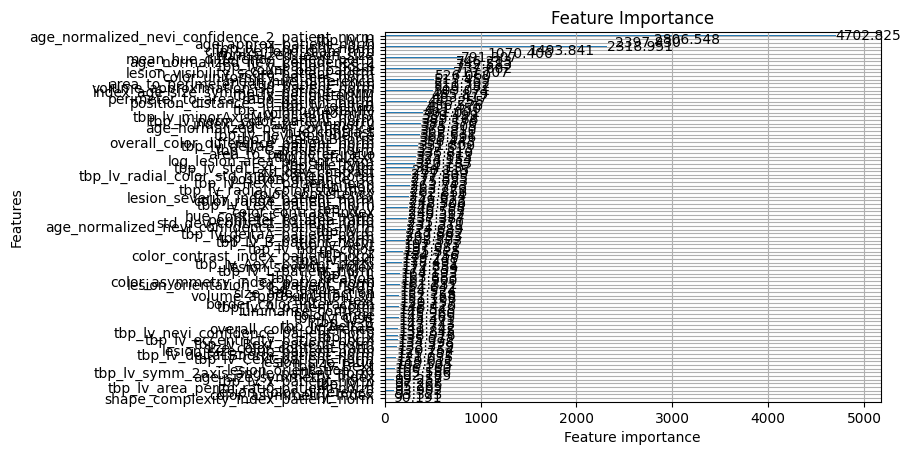

In [34]:
import matplotlib.pyplot as plt

# Plot feature importance
lgb.plot_importance(final_model2, max_num_features=100, importance_type='gain')
plt.title("Feature Importance")
plt.show()

In [35]:
X_test = df_test[feature_col]
sub = pd.DataFrame({'target':final_model2.predict_proba(X_test)[:,1]},index=ind)
sub.to_csv('submission.csv')
!head submission.csv

isic_id,target
ISIC_0015657,0.00015570955021453986
ISIC_0015729,6.656320571273799e-05
ISIC_0015740,0.0002665958253557025
